## **[Machine Learning for Forecasting: Transformations and Feature Extraction](https://towardsdatascience.com/machine-learning-for-forecasting-transformations-and-feature-extraction-bbbea9de0ac2)**
### *Supervised learning with time series. How to create univariate forecasting models using Python*


In this post, you’ll learn to apply supervised learning with time series using Python.

This includes two things:

- transforming time series from a sequence into a tabular format;
- adding new features based on summary statistics.

#### **Introduction**
Forecasting is one of the most studied problems in data science. The goal is to predict future values of a time series.

Accurate forecasts are invaluable for decision makers. They reduce future uncertainty, thereby improving the planning of operations.

Traditional approaches to forecasting include methods such as ARIMA or exponential smoothing. But, machine learning regression approaches are increasingly used to solve this problem.

Machine learning approaches frame the task as supervised learning. The goal is to create a model based on historical data. Yet, it’s not clear how one can train a model using a sequence of values as the input.

Turns out, there’s a neat transformation which allows us to do that.

#### **Time Delay Embedding**
A model is trained to derive patterns between observations and the consequences of those observations.

How do we do that with time series?

The value of a time series can be thought as the consequence of the past recent values before it. This value works as the target variable. The past recent values are used as explanatory variables.

Such process reshapes the series from a sequence of values into a tabular format. This transformation is called time delay embedding, and is the key of **auto-regression**.

Here’s a Python function to do it:

In [8]:
import pandas as pd
import numpy as np


def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Time delay embedding
    Time series for supervised learning
    :param series: time series as pd.Series
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast
    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    X = [series.shift(i) for i in n_lags_iter]
    X = pd.concat(X, axis=1).dropna()
    X.columns = [f'{name}(t-{j - 1})'
                if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                for j in n_lags_iter]

    return X.reset_index(drop = True)

Here’s the data set when this function is applied to the sequence from 1 to 9:

In [11]:
series = pd.Series(np.arange(1, 10).astype(int))
n_lags = 3
horizon = 1

X = time_delay_embedding(series, n_lags, horizon)
X

,Series(t-2),Series(t-1),Series(t-0),Series(t+1)
0,1.0,2.0,3.0,4
1,2.0,3.0,4.0,5
2,3.0,4.0,5.0,6
3,4.0,5.0,6.0,7
4,5.0,6.0,7.0,8
5,6.0,7.0,8.0,9


Take the first row an example. The goal is to predict the number 4 (column Series(t+1)). The explanatory variables are the past 3 values before it: 3, 2, and 1.

Time delay embedding has a strong theoretical foundation. You can check reference [1] for details. Embedding theorems posits that time series are equivalent before and after transformation.

#### **Complete Example**
Let’s code a complete example. We’ll use the sunspots time series. This data set is available in *pmdarima* library. Here’s how it looks:

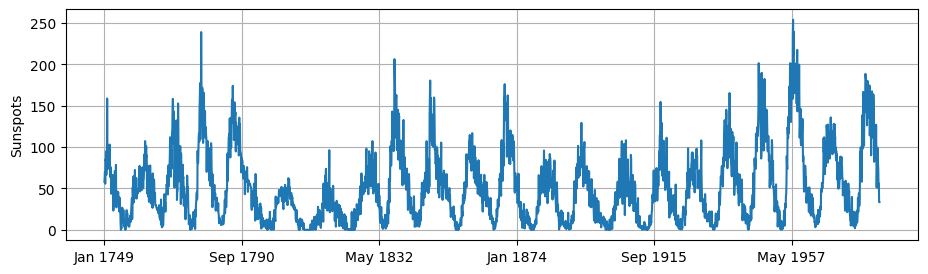

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
from pmdarima.datasets import load_sunspots
import matplotlib.pyplot as plt

# loading the sunspots time series
# taking first differences to stabilize the mean
data = load_sunspots(as_series=True)
data.plot(figsize = (11, 3), grid = True, ylabel = 'Sunspots')
plt.axis('tight')
plt.show()

Below is an example of how to transform the time series, and train an auto-regressive model.

Check the comments for a bit more context in each step.

In [57]:
mae_list

[]

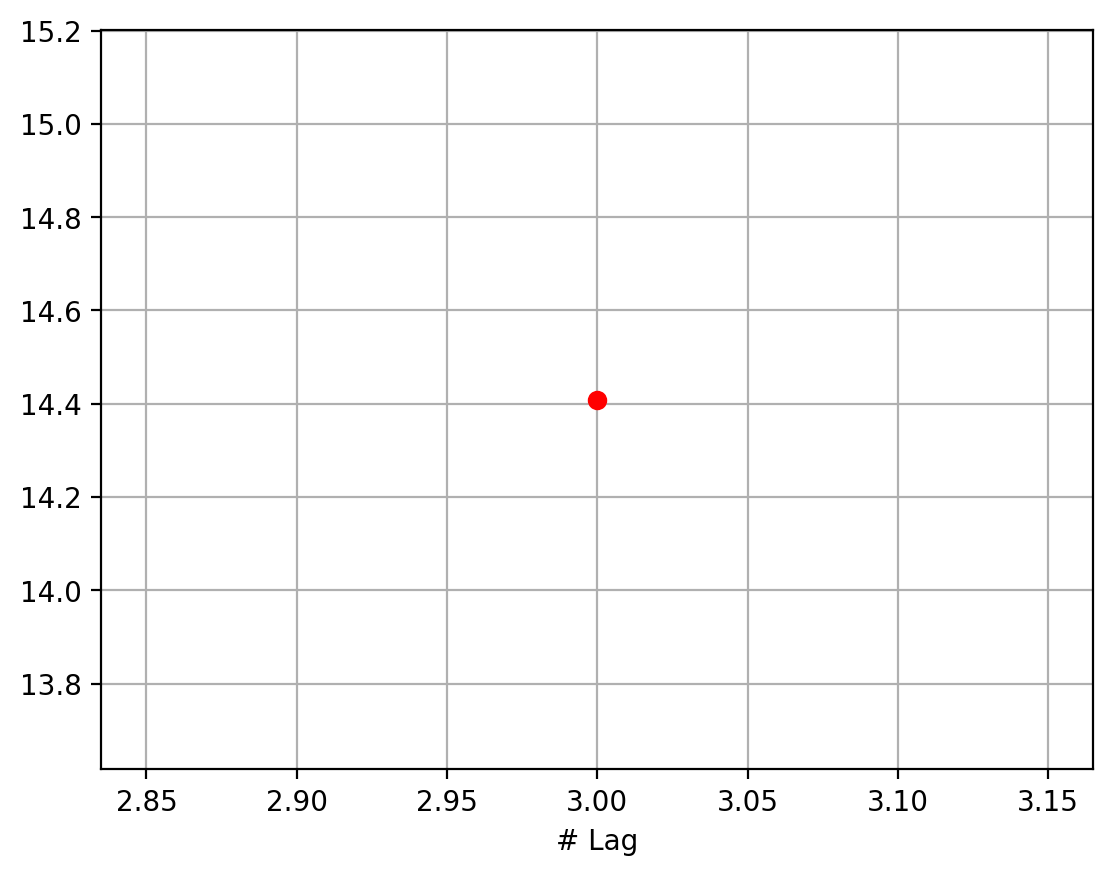

[14.408279068100358]

In [60]:
lag_list, mae_list = [], []
for n_lag in range(3, 4):
    # applying time delay embedding
    # using 3 lags (n_lags=3) to predict the next value (horizon=1)
    ts = time_delay_embedding(series=data, n_lags=n_lag, horizon=1)
    lag_list.append(n_lag)

    # splitting target variable from explanatory variables
    target_columns = ts.columns.str.contains('\+')
    X = ts.iloc[:, ~target_columns]
    y = ts['Series(t+1)']

    # train/test split
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.33, shuffle=False)

    # fitting a random forest
    model = RandomForestRegressor()
    model.fit(X_tr, y_tr)

    # getting forecasts for the test set
    predictions = model.predict(X_ts)

    # computing MAE error
    mae_list.append(mae(y_ts, predictions))
    # 13.73

plt.figure(dpi = 200)
plt.plot(lag_list, mae_list)
ind_best = np.array(mae_list).argmin()
plt.plot(lag_list[ind_best], mae_list[ind_best], 'ro')
plt.grid()
plt.xlabel('# Lag')
plt.show()

mae_list

Text(0.5, 1.0, 'Partial Autocorrelation Function')

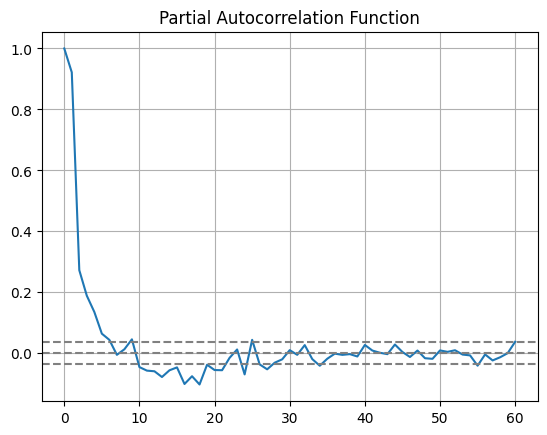

In [61]:
from statsmodels.tsa.stattools import acf, pacf

lag_pacf = pacf(data.values, nlags = 60, method = 'ols')
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(series.shape[0]), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(series.shape[0]), linestyle = '--', color = 'gray')
plt.grid()
plt.title('Partial Autocorrelation Function')

#### **Number of Lags and Forecasting Horizon**
Transforming the time series requires specifying the number of lags. That is, how many recent past values we should use to predict the next point.

There are a few prescriptions for this. For example, **_checking partial auto-correlation and determine where it is significant. You can also optimize this parameter using cross-validation._**

Another parameter is the forecasting horizon. This is the number of future steps you want to forecast. If this value is 1, the problem is referred to as one-step ahead forecasting. Or, multi-step ahead forecasting otherwise.

It’s worth mentioning that the transformation does not replace other preprocessing steps.

**_You still need to account for trend and seasonal components, and remove them if needed._**

#### **Feature Extraction**

There is a basic assumption behind auto-regression methods. Past lags contain enough information about how the series will evolve.

Yet, you can derive more information from these.

In machine learning, feature engineering is a crucial part of building accurate models. This can be done for forecasting problems as well.

We can summarise recent values using statistics. These statistics enrich the representation of time series. Hopefully, this translates into better forecasting performance.

For example, the average of the past few values can be useful. It gives a smoothed indicator of the level of the series at each point.

Here’s an example. I repeated the code above, but added a feature engineering step (lines 20–22).

In [63]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
from pmdarima.datasets import load_sunspots

# loading the sunspots time series
series = load_sunspots(as_series=True).diff()

# applying time delay embedding
ts = time_delay_embedding(series=series, n_lags=3, horizon=1)

# splitting target variable from explanatory variables
target_columns = ts.columns.str.contains('\+')
X = ts.iloc[:, ~target_columns]
y = ts['Series(t+1)']

# train/test split
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.33, shuffle=False)

# adding the mean as features
X_tr['mean'] = X_tr.mean(axis=1)
X_ts['mean'] = X_ts.mean(axis=1)

# fitting a random forest
model = RandomForestRegressor()
model.fit(X_tr, y_tr)

# making predictions
predictions = model.predict(X_ts)

# computing error
mae(y_ts, predictions)
# 13.23

13.360611106311568

In lines 21 and 22 I added the average of the lags as explanatory variables. This leads to a small gain in forecasting performance.

Here’s how feature importance looks like:

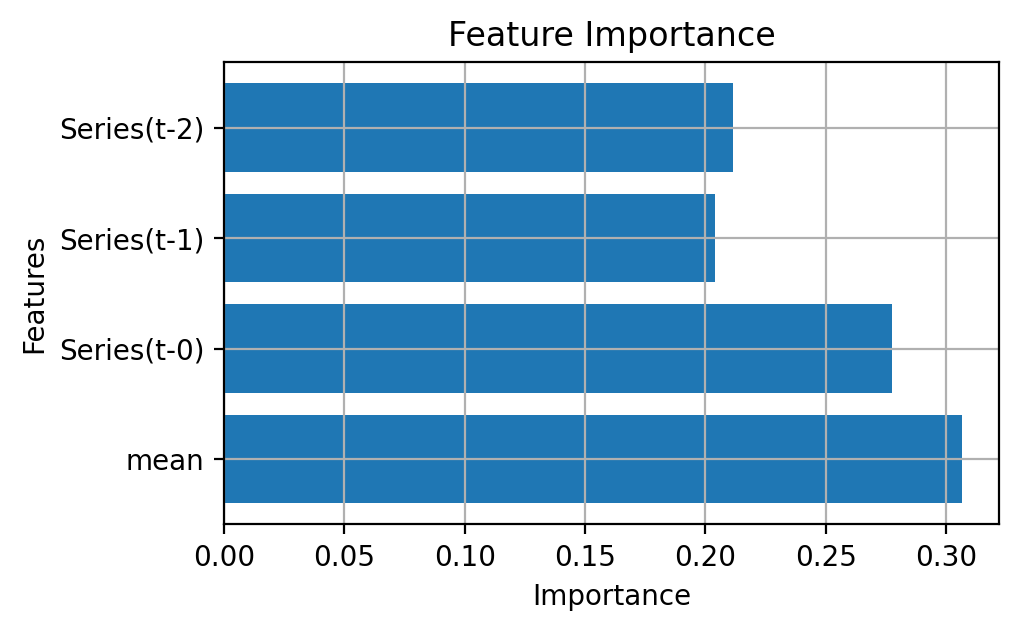

In [77]:
fig, ax = plt.subplots(figsize = (5, 3), dpi = 200)

ax.barh(X_tr.columns, model.feature_importances_)
ax.set_yticks(X_tr.columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')
plt.grid()
plt.show()

The mean feature is the most important one.

I added a single feature in this example. But, you’re limited only by your imagination.

You can test several other summary statistics and check if they improve the model.

#### **Takeaways**
- Use time delay embedding to transform a time series into a matrix
- Values in time series are modelled based on their past lags (auto-regression)
- Select the number of lags with partial auto-correlation analysis or cross-validation
- Extract more features from past lags using summary statistics

Thanks for reading, and see you in the next story!